<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/NN_ML_Summit_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Einführung in Neuronale Netzwerke mit TensorFlow

In diesem Workshop erarbeiten wir uns die Grundlagen von Neuronalen Netzwerken anhand eines einfachen Klassifikationsproblems. Dabei nutzen wir ein Colab Notebook und beschäftigen uns damit wie ein künstliches Neuron funktioniert und wie man daraus ein Netzwerk baut und es trainiert.

Voraussetzung: Grundkenntnisse im Bereich Supervised Machine Learning

https://ml-summit.de/machine-learing/einfuehrung-in-neuronale-netzwerke-mit-tensorflow/

Dieses Notebook: https://bit.ly/ml-summit-2021-tf

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
tf.random.set_seed(42)

In [3]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [6]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = .05  # step size in the mesh
#     x_min, x_max = -0.1, 1.1
#     y_min, y_max = -0.1, 1.1

    x_min, x_max = x_data.min() - .1, x_data.max() + .1
    y_min, y_max = y_data.min() - .1, y_data.max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   ax=None, marker_size=100
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      _, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        # ax.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=.6)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

        # Z_binary = (Z > 0.5).astype(int)
        # ax.contourf(xx, yy, Z_binary, cmap=plt.cm.RdBu, alpha=.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='o', edgecolors='k', s=classes*marker_size)
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='^', edgecolors='k', s=~classes.astype(bool)*marker_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    return ax

# Predicting a category

* we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binary classification

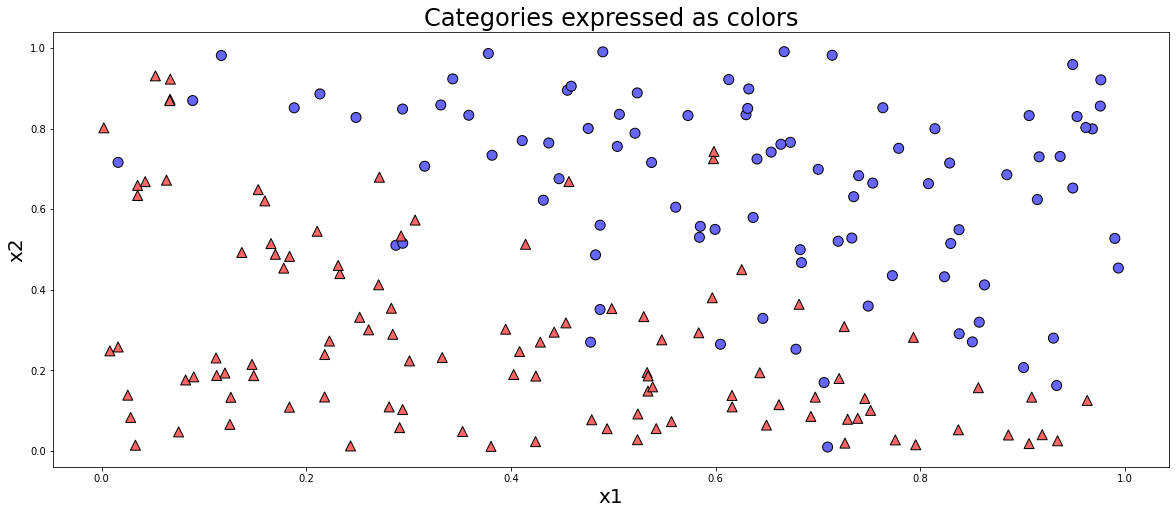

In [75]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 200 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import pandas as pd
import numpy as np

# np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF6666', '#6666FF'])

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='^', edgecolors='k', s=~y_bool*size);

x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

# Shared Exercise
## Can you think of an application for this? What could be on the axes?

_Let's adapt the example to something we can relate to_

### We have two dimensions as input

In [8]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

X.shape, y.shape

((200, 2), (200,))

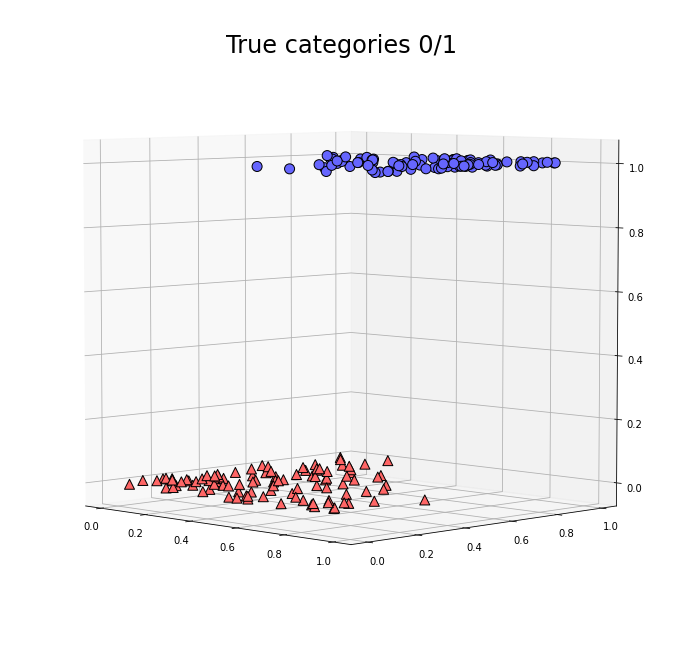

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('True categories 0/1')

# we can have the probability encoded in shade of color
ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=cmap,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y*size)

ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=cmap,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_bool*size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=5, azim=-45)

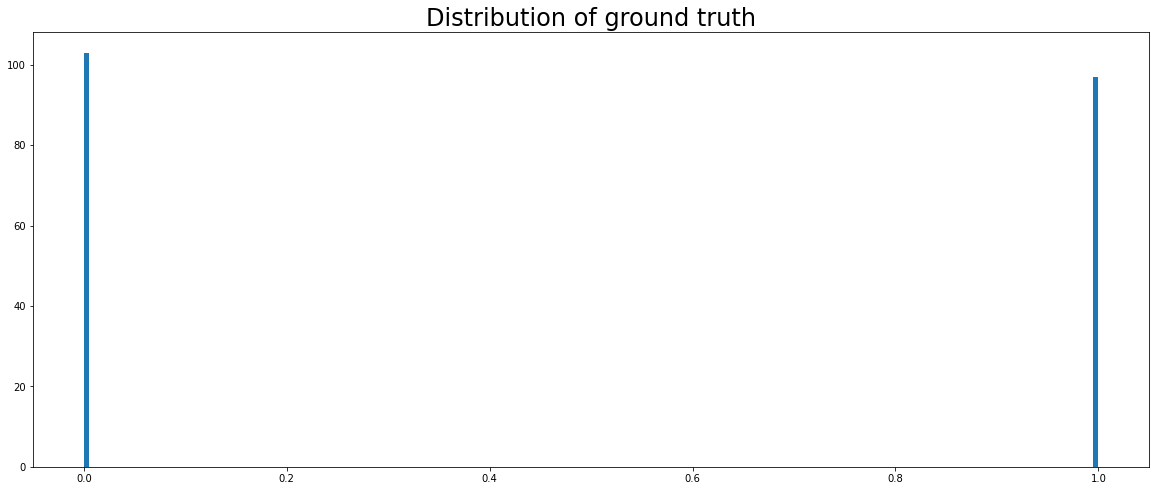

In [10]:
plt.hist(y, bins=n)
plt.title('Distribution of ground truth');

# Model

## We model this as a linear problem

<img src='https://djcordhose.github.io/ml-workshop/img/neuron-v2.png'>

# Implementation and Prediction using TensorFlow

In [11]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_pred = model.predict(x)
# y_pred

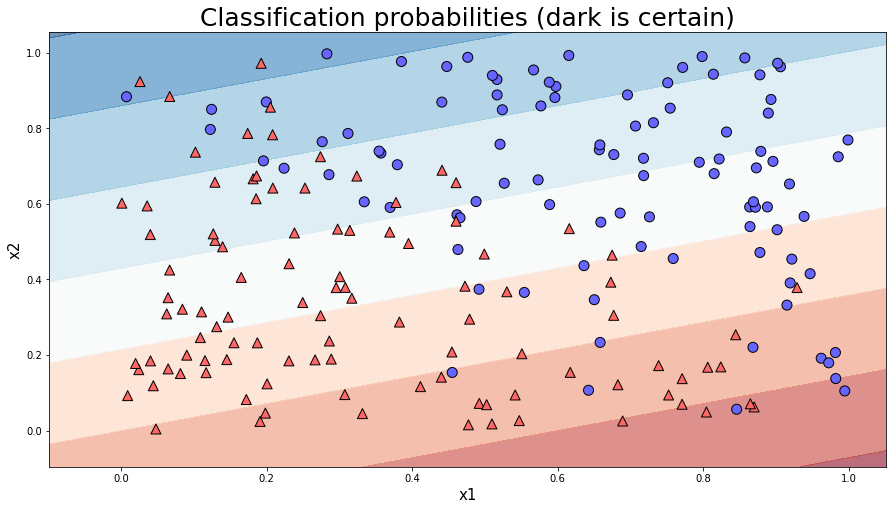

In [13]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities (dark is certain)");

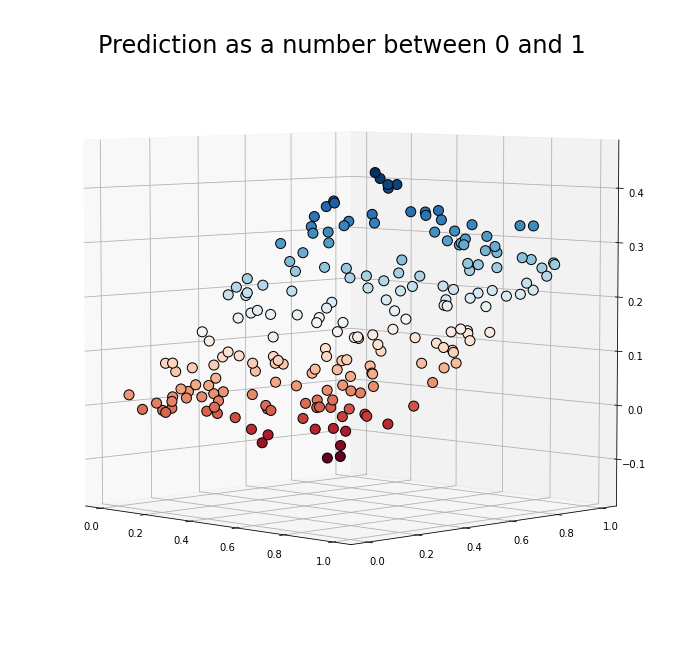

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Prediction as a number between 0 and 1')

# we can have the probability encoded in shade of color
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred.ravel(), 
           cmap=plt.cm.RdBu,
           marker='o', 
           depthshade=False,
           edgecolors='k',
           s=size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=5, azim=-45)
# ax.view_init(elev=10, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

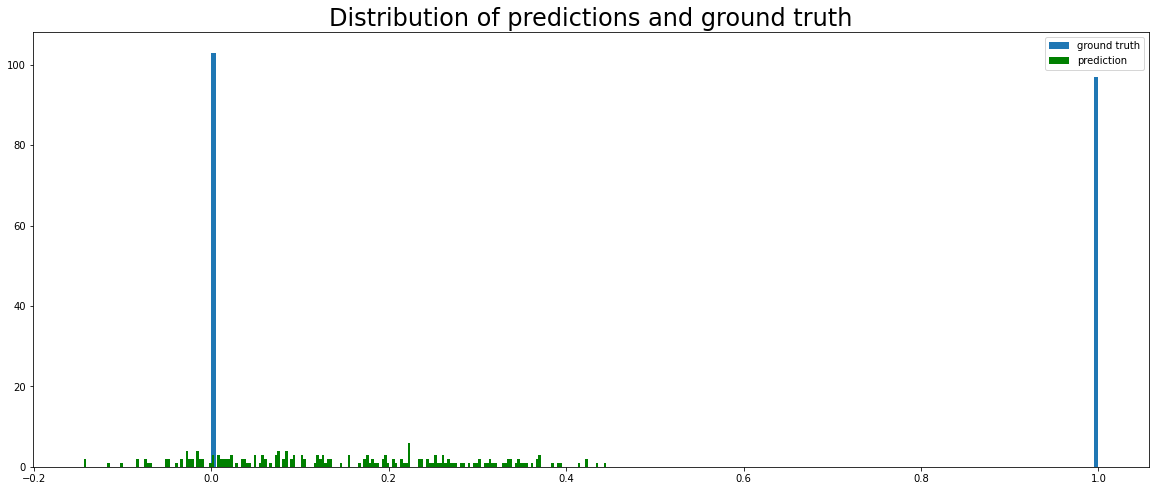

In [15]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions and ground truth');

## Turning a value between 0 and 1 into a binary decision

_everything below 0.5 counts as 0, everthing above as 1_

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/logistic.jpg?raw=1'>

In [16]:
# y_pred

In [17]:
threshold = 0.5

In [18]:
y_pred_binary = (y_pred > threshold).astype(int).ravel()
y_pred_binary

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

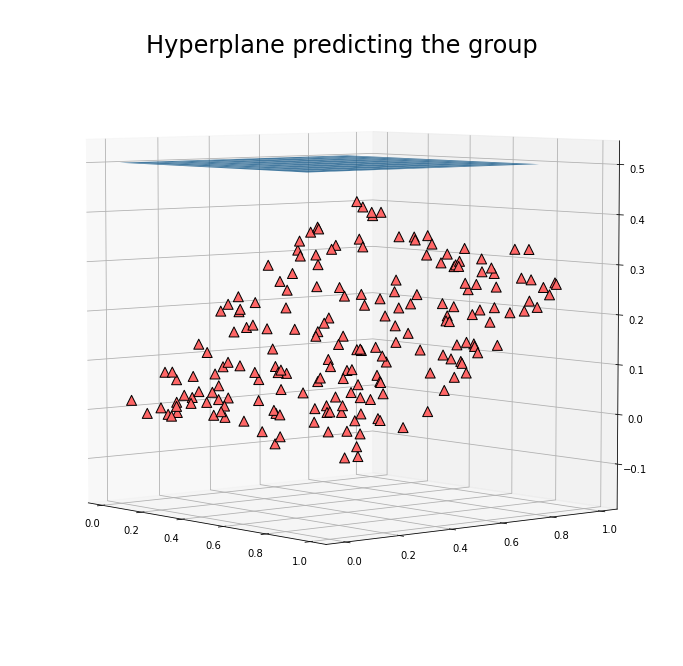

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hyperplane predicting the group')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

xx,yy = np.meshgrid(np.arange(0.0, 1.0, 0.1), np.arange(0.0, 1.0, 0.1))
zz = np.full(xx.shape, threshold)
ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

# Metrics

We know our model is wrong, but by how much?

## Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [20]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred)).numpy()

0.33580014

## Accuracy: what share of predictions is correct?

* basic metric for classification: share of correctly predicted samples
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy


In [21]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y, y_pred_binary)
accuracy.result().numpy()

0.515

In [22]:
# same, but includes the thresholding, y_pred instead of y_pred_binary

accuracy = tf.keras.metrics.BinaryAccuracy()
accuracy.update_state(y, y_pred)
accuracy.result().numpy()

0.515

# Training

### Optimizing the model

So far the model just predicts using random parameters

## loss/error depends on our model and its parameters

<img src='https://djcordhose.github.io/ml-workshop/img/loss.png'>

## In a loop we change the parameters in the direction of bringing the loss down

Therefore we compute the derivative of each parameter influencing the loss

In [23]:
%%time 

# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

EPOCHS = 1500

losses = []
accuracies = []

# the thing that actually does the updat
optimizer = tf.keras.optimizers.Adam()

for step in range(EPOCHS):
  accuracy = tf.keras.metrics.BinaryAccuracy()
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = model(x)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  accuracy.update_state(y_true, y_pred)
  accuracies.append(accuracy.result().numpy())

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our neuron.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

CPU times: user 18.7 s, sys: 45.3 ms, total: 18.7 s
Wall time: 18.8 s


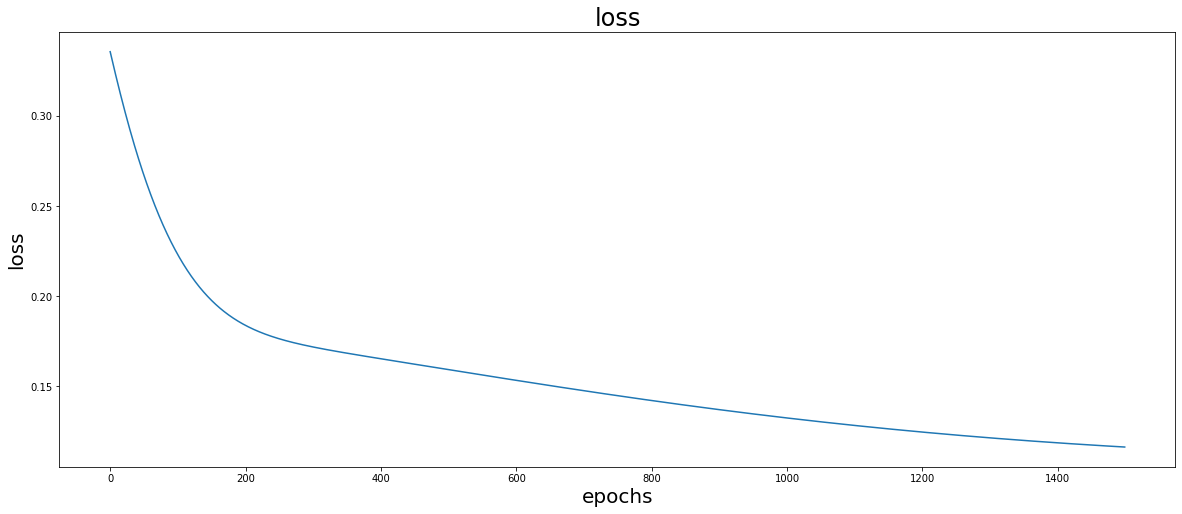

In [24]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('loss')

plt.plot(losses);

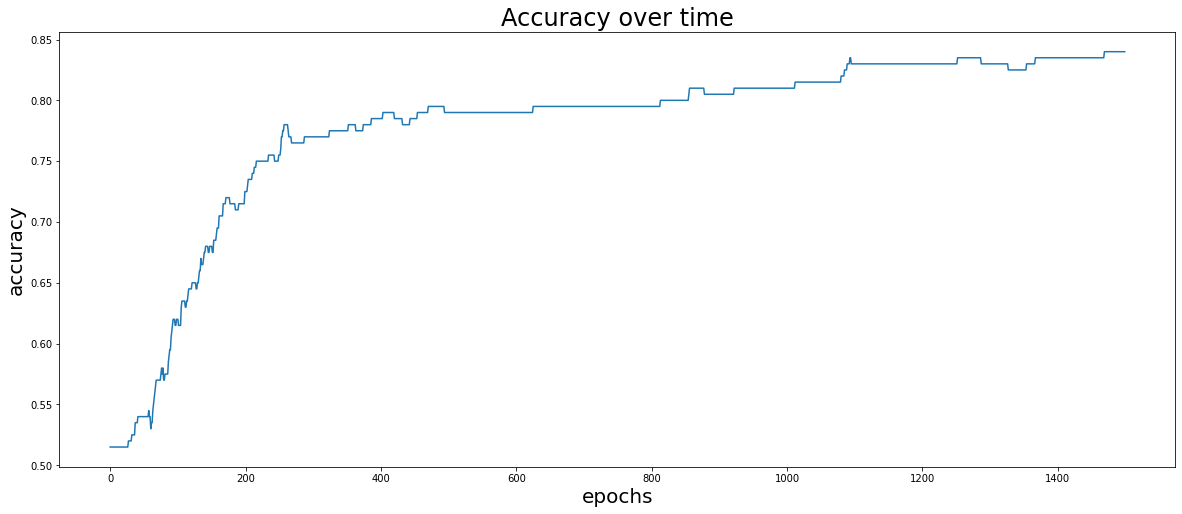

In [25]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(accuracies);

In [26]:
y_pred = model.predict(x)
y_pred_binary = (y_pred > threshold).astype(int).ravel()
y_pred_binary

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1])

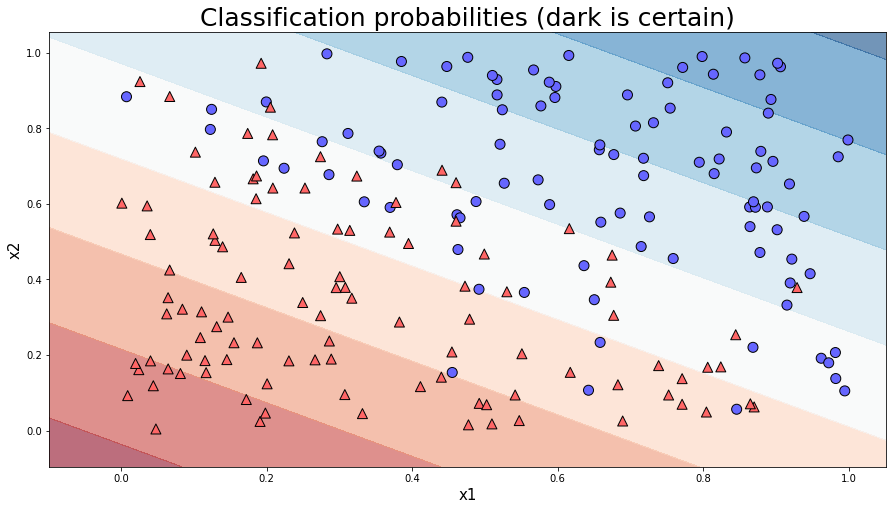

In [27]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities (dark is certain)");

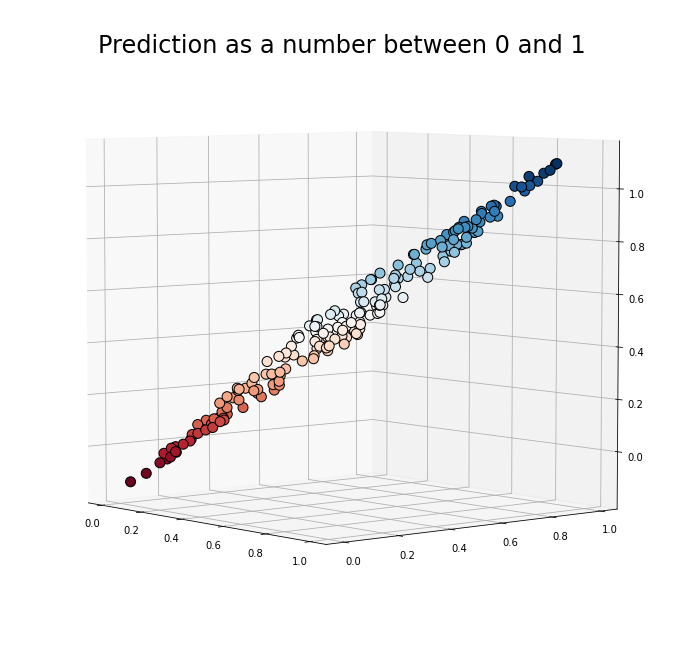

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Prediction as a number between 0 and 1')

# we can have the probability encoded in shade of color
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred.ravel(), 
           cmap=plt.cm.RdBu,
           marker='o', 
           depthshade=False,
           edgecolors='k',
           s=size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=5, azim=-40)
# ax.view_init(elev=10, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

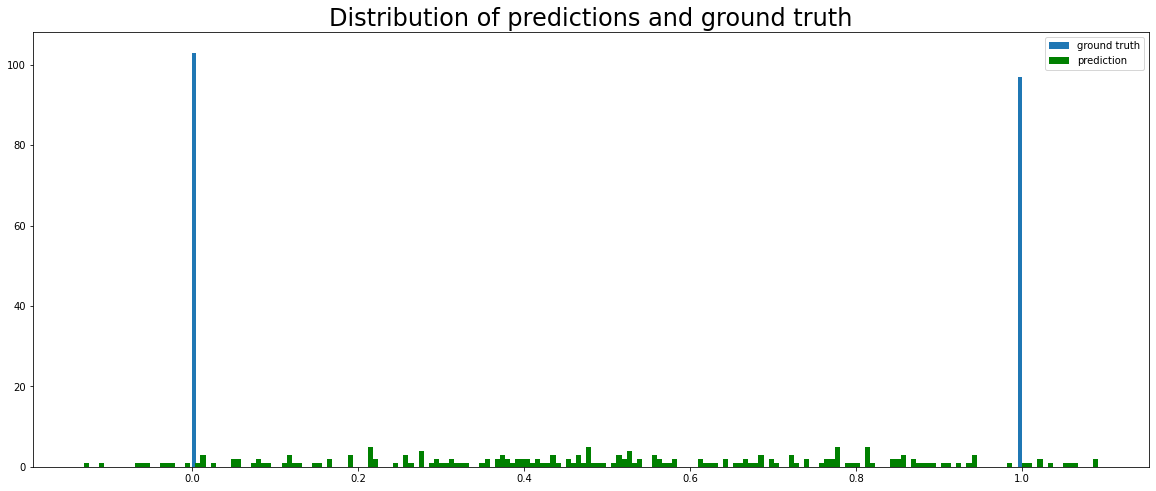

In [29]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions and ground truth');

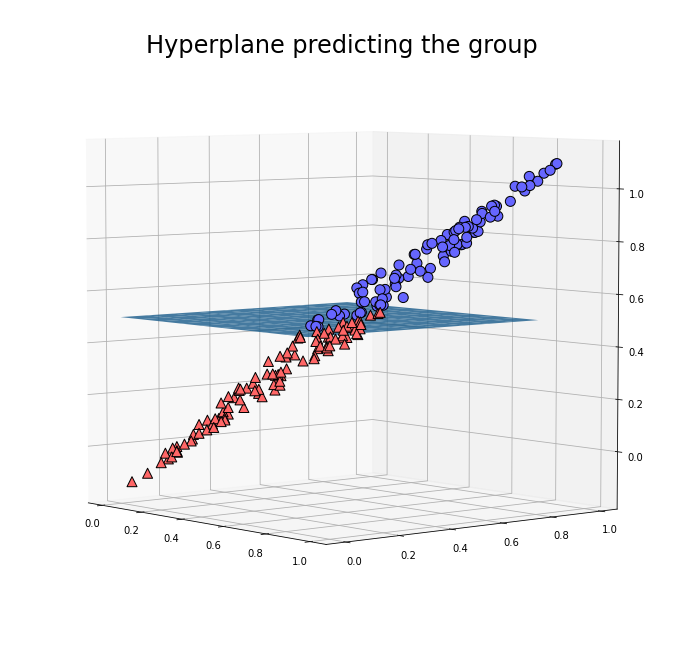

In [30]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hyperplane predicting the group')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

xx,yy = np.meshgrid(np.arange(0.0, 1.0, 0.1), np.arange(0.0, 1.0, 0.1))
zz = np.full(xx.shape, threshold)
ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

### Interpretation

* some values are negative
* some are above 1
* we have a lot of variance

# Training revisited

## Keras vs TensorFlow

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/keras-vs-tensorflow.jpg?raw=1'>

https://twitter.com/fchollet at http://scaledml.org/2020/

In [31]:
%%time 

model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2))

model.compile(loss='mse', 
             optimizer='adam',
              metrics=['accuracy'])

# replaces loop
history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 11.4 s, sys: 868 ms, total: 12.3 s
Wall time: 9.76 s


In [32]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.10724197328090668, 0.8700000047683716)

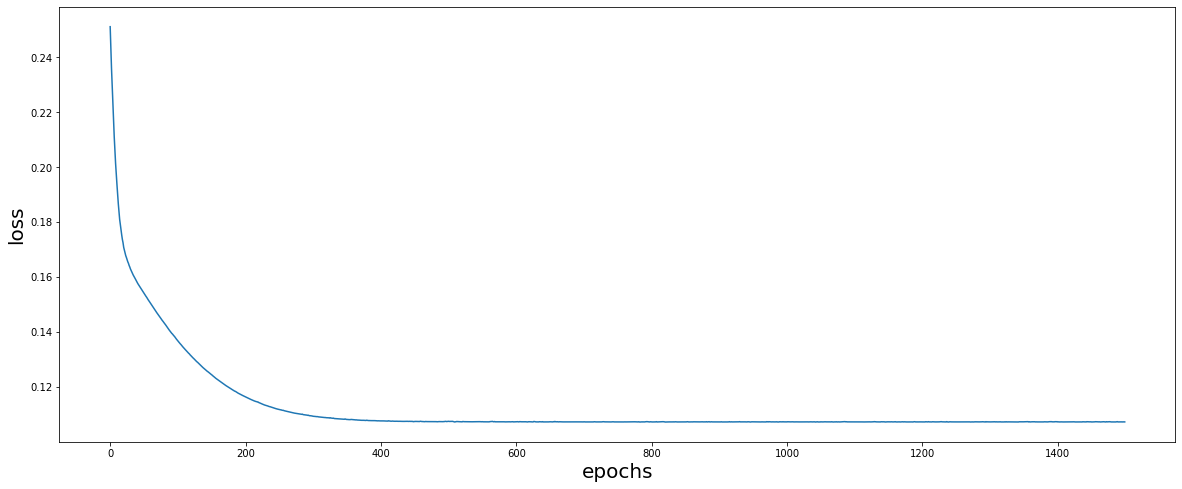

In [33]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);

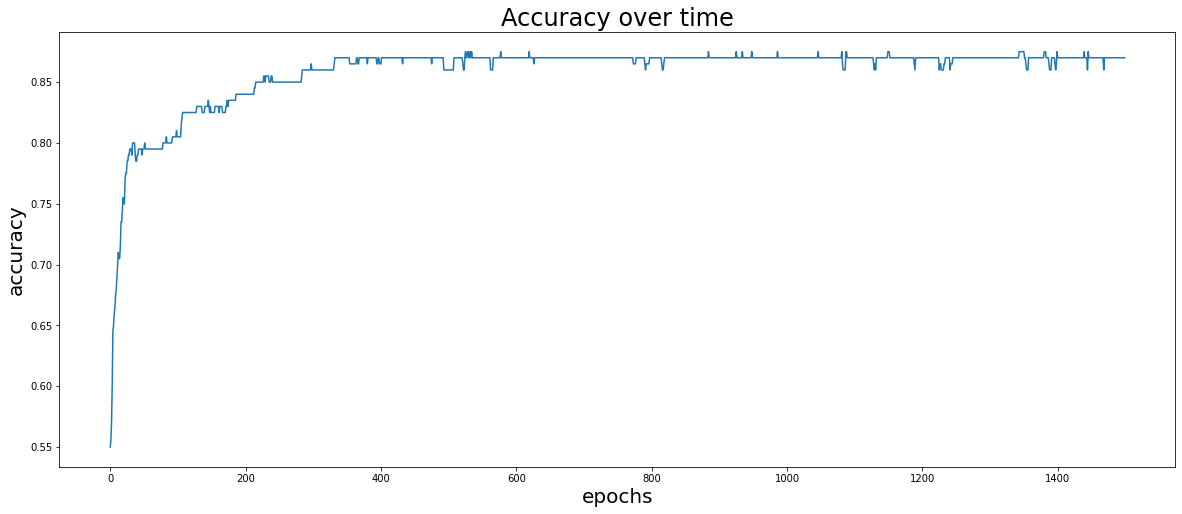

In [34]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

# Logistic Regression


Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://djcordhose.github.io/ml-workshop/img/activation/neuron-sigmoid.png'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ml-workshop/img/activation/activation-functions.jpg'>

### We can use sigmoid as the activation function

In [35]:
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Reconsidering the loss function


What makes a great loss function?
* penalizes very confident misclassifications strongly 
* you want the gradients to be steep, not shallow towards the minumum
* small errors need more shallow gradients
* perfect predictions need zero loss

### Binary Cross-Entropy / Log Loss

gives unbounded loss, $Y_{i}$ are assumed to only be 0 or 1

$xent = -{\frac {1}{n}}\sum _{i=1}^{n}(Y_{i} \cdot \ln{({\hat {Y_{i}}})}) + ((1-Y_{i}) \cdot \ln{(1 - {\hat {Y_{i}}})})$

__First term cancels out if ground truth $Y_{i}$ is 0, second if it is 1__

https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a



### binary cross-entropy / log loss as an alternative to mean squared error


In [36]:
# MSE will never be more than one
tf.losses.mean_squared_error(y_true=[[1], [1], [1]], y_pred=[[0.1], [0.01], [0.001]]).numpy()

array([0.80999994, 0.98010004, 0.99800104], dtype=float32)

In [37]:
# imperfections give unbounded losses (uses ln)
tf.losses.binary_crossentropy(y_true=[[1], [1], [1]], y_pred=[[0.1], [0.01], [0.001]]).numpy()

array([2.3025842, 4.60516  , 6.9076552], dtype=float32)

In [38]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=2000, verbose=0)

CPU times: user 16.8 s, sys: 1.3 s, total: 18.1 s
Wall time: 14.1 s


In [39]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.3212743103504181, 0.8600000143051147)

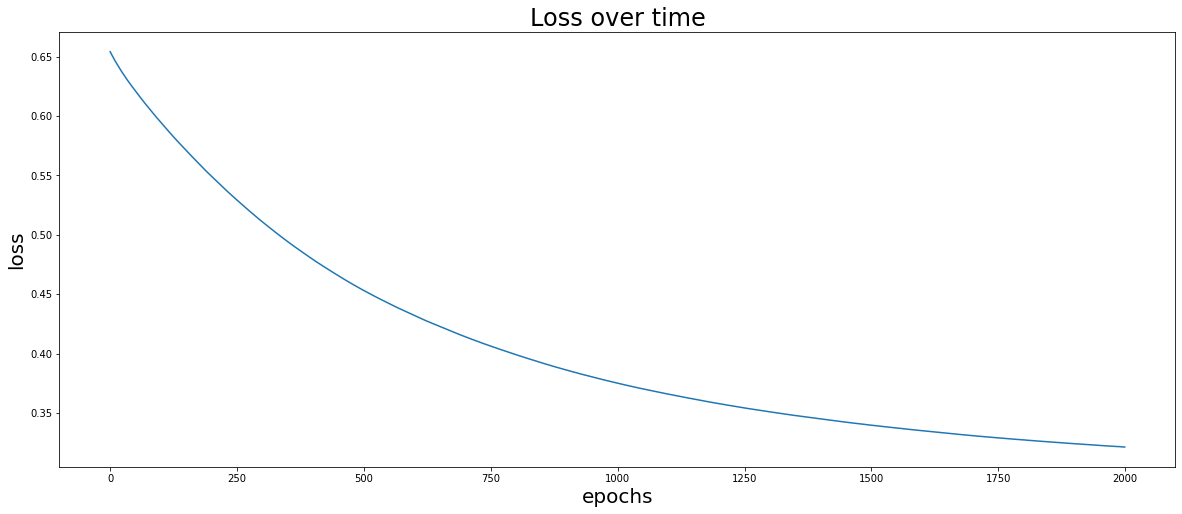

In [40]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

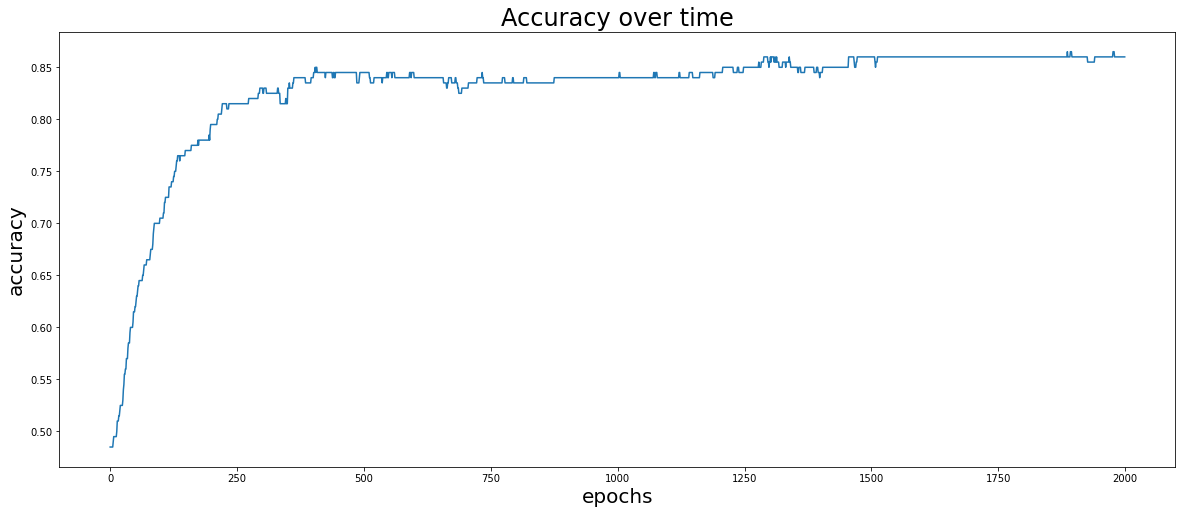

In [41]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [42]:
y_pred = model.predict(x)

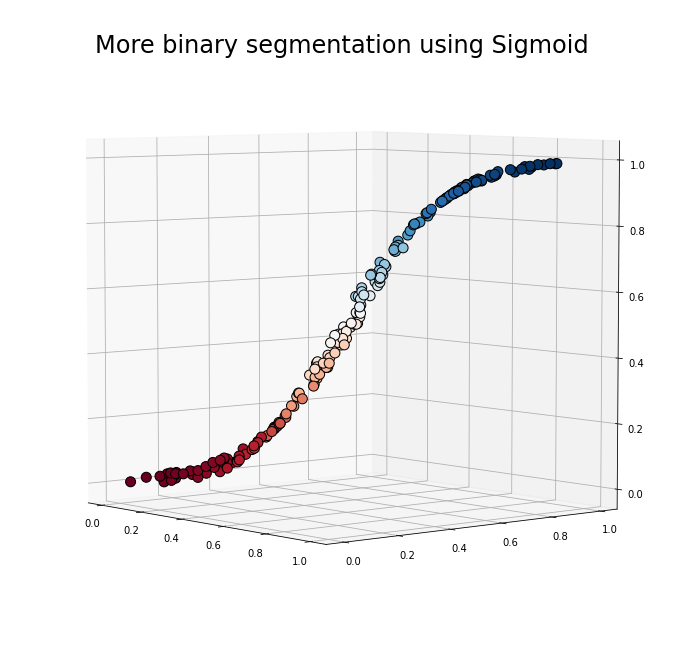

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('More binary segmentation using Sigmoid')

# we can have the probability encoded in shade of color
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred.ravel(), 
           cmap=plt.cm.RdBu,
           marker='o', 
           depthshade=False,
           edgecolors='k',
           s=size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=5, azim=-40)
# ax.view_init(elev=10, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

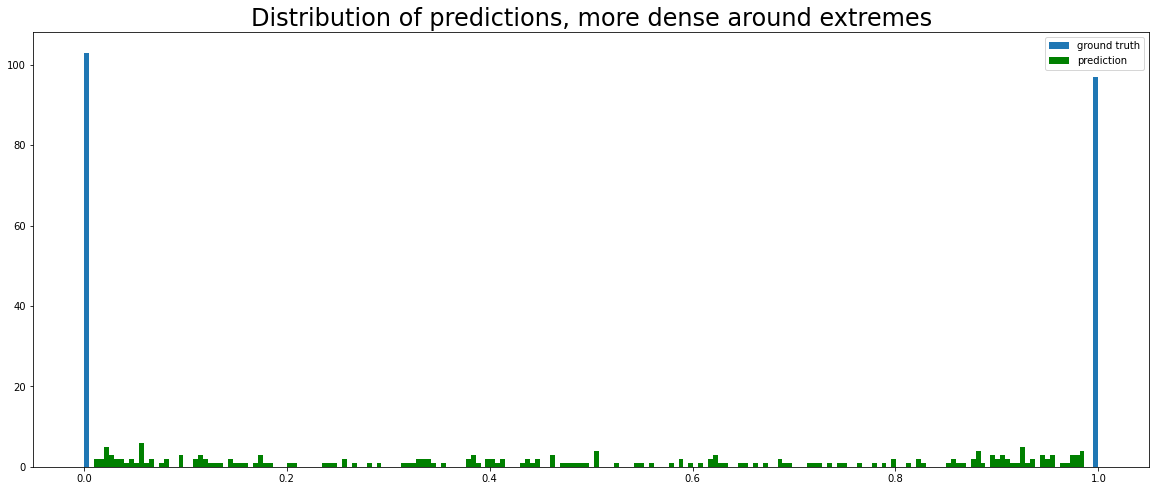

In [44]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, more dense around extremes');

In [45]:
y_pred_binary = (y_pred > threshold).astype(int).ravel()

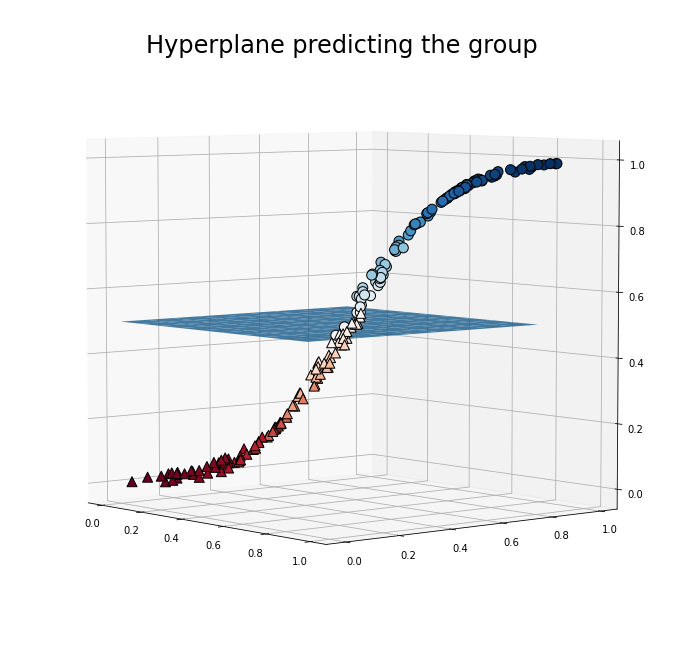

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hyperplane predicting the group')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

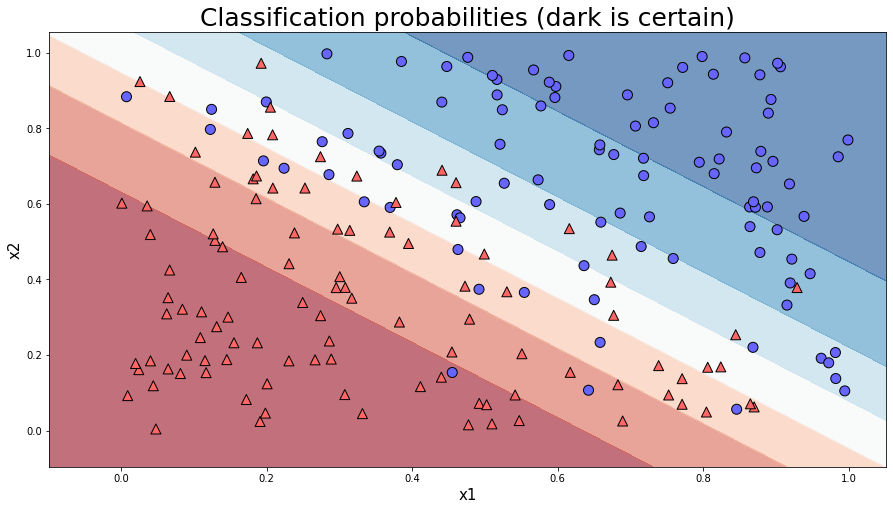

In [47]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities (dark is certain)");

# Hands-On I: run this classification experiment

* generated your own dataset (maybe using a bit more noise)
* train the model and generate all the plots
* use both losses on the final model

# Deep Learning

Neural Networks with 2-3 Layers and non-linear activation can learn to draw any decision boundary or approximate any continuous function


## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/

## Interpration of Deep Learning

* the final layer combines all previous inputs into a single prediction
  * either a linear transformation or
  * a binary prediction or
  * a multi class prediction
* intermediate (hidden) layers transform the problem in way to make it linear or accessible to a logistic function
* ideally this replaces any manual feature engineering   



In [48]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


In [49]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 24.3 s, sys: 2.25 s, total: 26.5 s
Wall time: 18.1 s


In [50]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.13232563436031342, 0.9350000023841858)

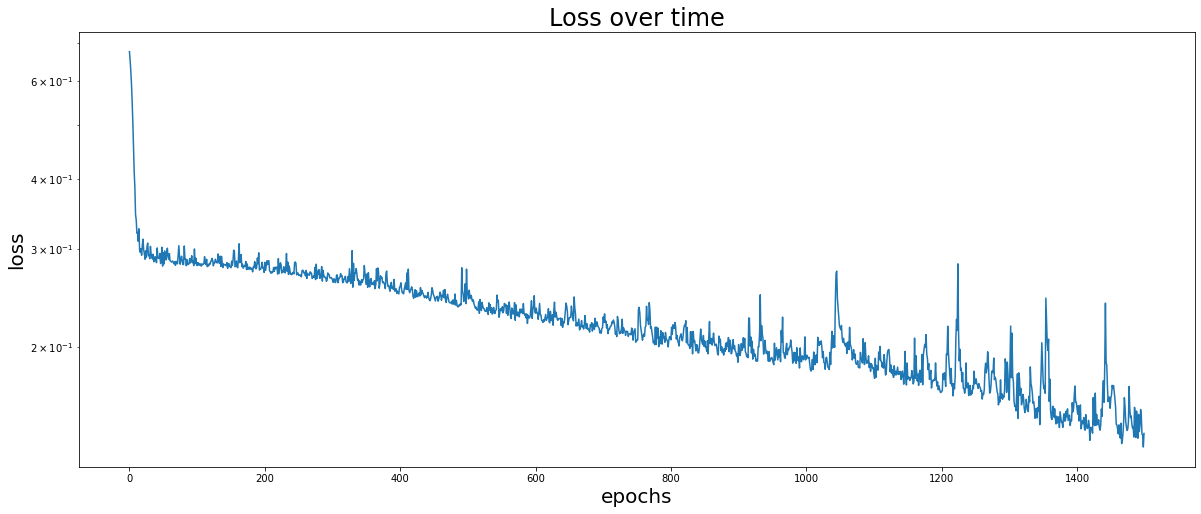

In [51]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

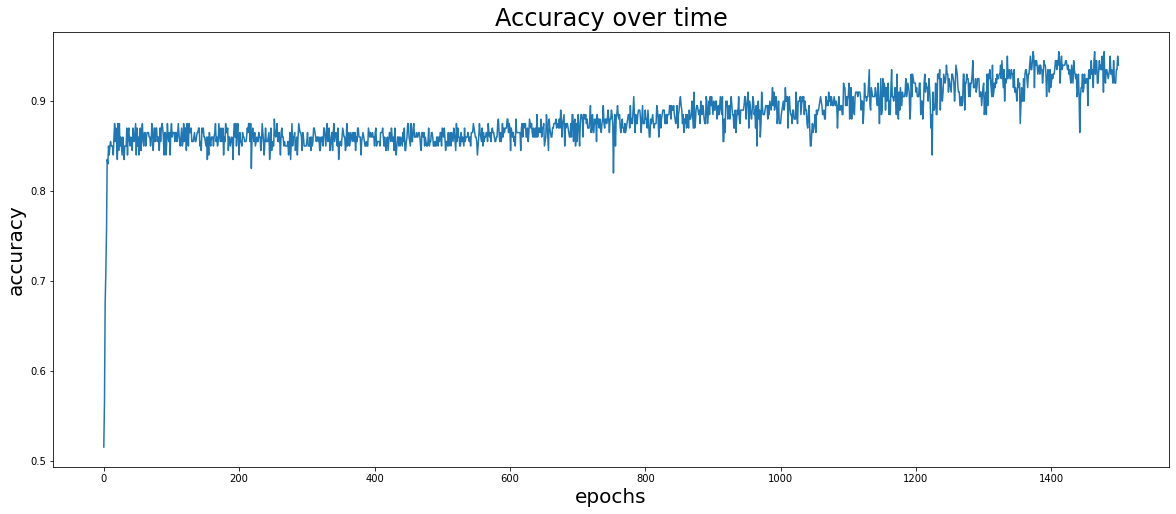

In [52]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

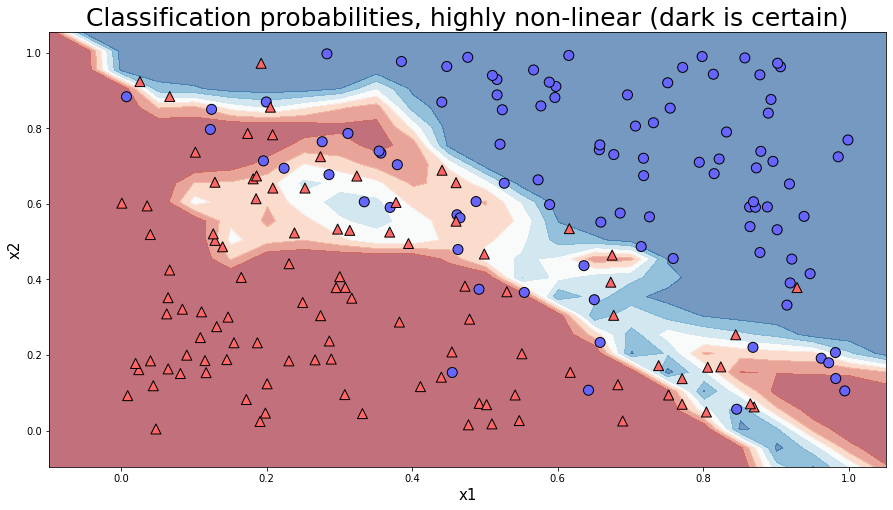

In [53]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities, highly non-linear (dark is certain)");

In [54]:
y_pred = model.predict(x)
y_pred_binary = (y_pred > threshold).astype(int).ravel()

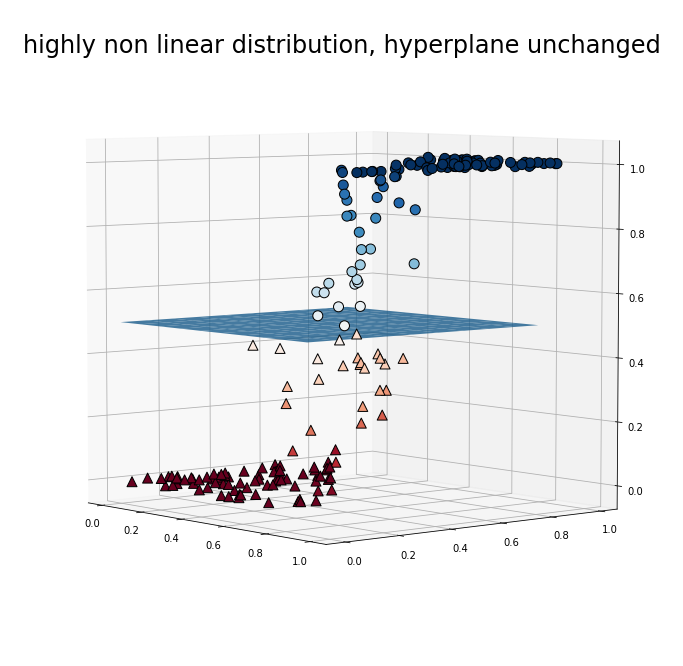

In [55]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('highly non linear distribution, hyperplane unchanged')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

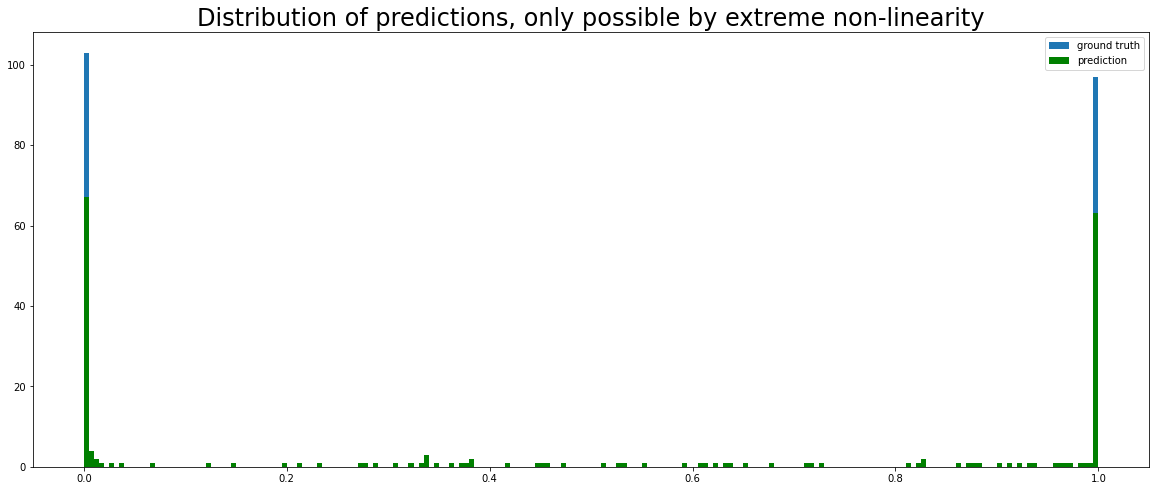

In [56]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, only possible by extreme non-linearity');

# Hands-On II: Can you create a perfect model?

* use the playground to experiment with hidden layers
* under the hood the playground also uses a final neuron with tanh activation to decide between the two categories
* play with the existing model, 
  * add or remove layers
  * change number of neurons per layer
  * change number of epochs
  * change loss or activation
  * etc.

*use the accuracy metric evaluate your model, decision boundary plot is not quite accuarate unfortunately*

# Optional: Alternative Approach: one-hot encoding the prediction for multi-class prediction

* one output unit per category
* encoding of outout is one-hot
* highest value (argmax) determines most likely class 
* softmax is a smooth version of argmax, its output can be interpreted as probabilities adding up to 1
* ideal with categorical crossentropy (not binary)
* multi-label output would be sigmoid with binary cross entropy, each output node would encode an hypothesis of its own, we just sum up all the errors

Sources:
* https://en.wikipedia.org/wiki/Cross_entropy 
* https://www.youtube.com/watch?v=ErfnhcEV1O8
* https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [57]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=2, activation='softmax')) # the change is here
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [58]:
%%time 
 
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 21.3 s, sys: 2.02 s, total: 23.3 s
Wall time: 16 s


In [59]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.1667376309633255, 0.925000011920929)

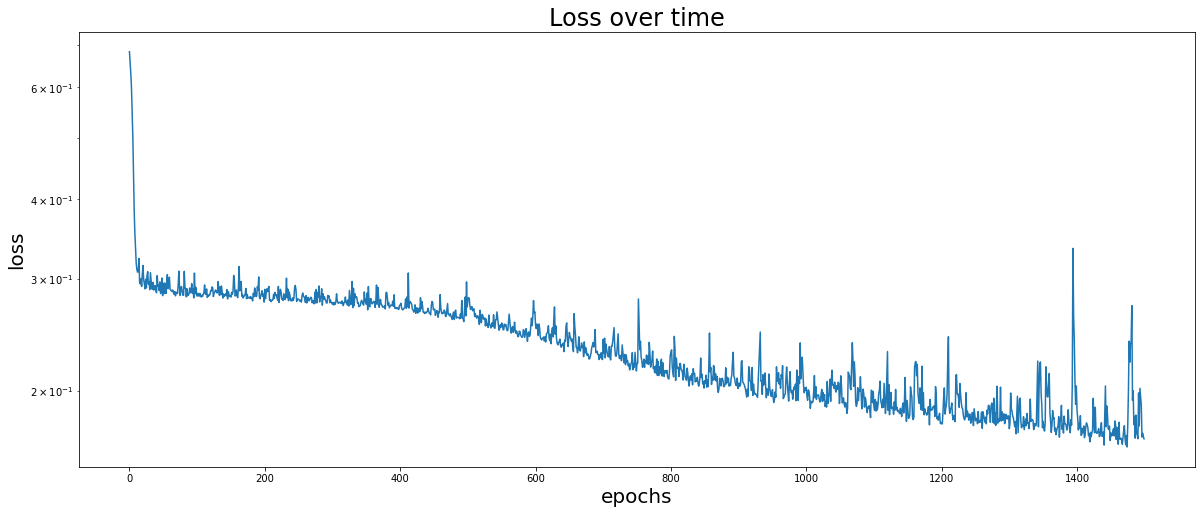

In [60]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

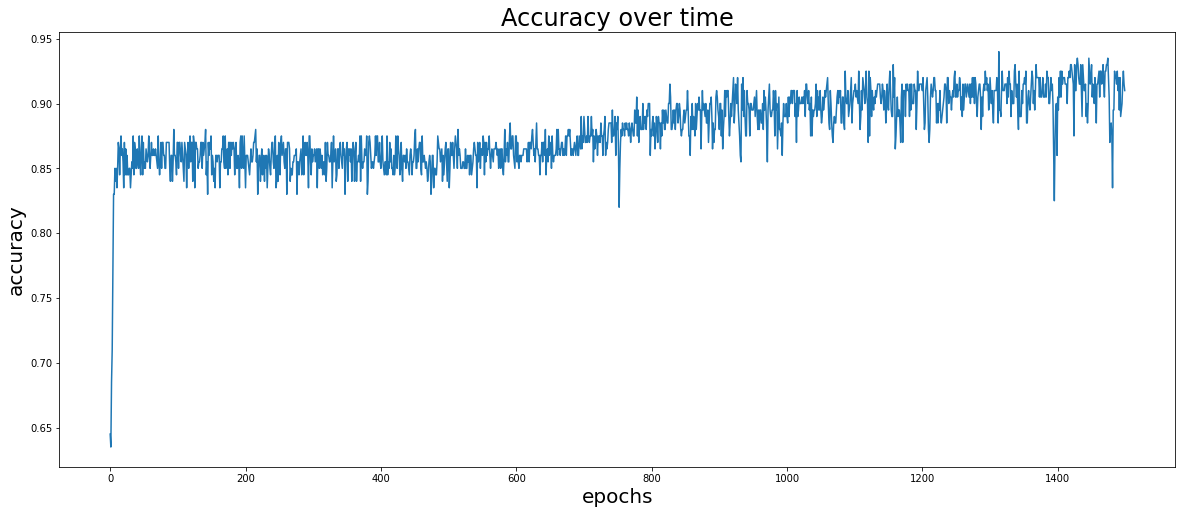

In [61]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [62]:
y_pred = model.predict(x)
y_pred_binary = y_pred.argmax(axis=1) # new way of determining the prediction
y_pred.shape, y_pred_binary.shape

((200, 2), (200,))

In [63]:
y_one_hot = tf.one_hot(y, 2)
y.shape, y_one_hot.shape

((200,), TensorShape([200, 2]))

In [64]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
accuracy.update_state(y_one_hot, y_pred)
accuracy.result().numpy()

0.925

## Confusion Matrix
* row: true
* column: predicted

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

uniq_labels = ['0 / red', '1 / blue']
def plot_cm(model, X, y):
  y_pred = model.predict(X).argmax(axis=1)
  cm = confusion_matrix(y, y_pred)
  figure = plt.figure(figsize=(10, 10))

  sns.heatmap(cm, annot=True, xticklabels=uniq_labels, yticklabels=uniq_labels, cmap='Blues', fmt='d')

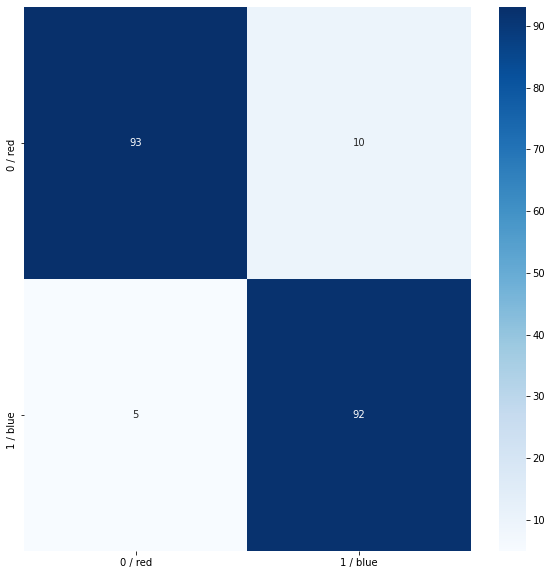

In [73]:
plot_cm(model, X, y)

# Saving and loading model

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [68]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
model.save('classifier.h5')

In [69]:
!ls -l

total 288
-rw-r--r-- 1 root root 286800 Mar 30 12:25 classifier.h5
drwxr-xr-x 1 root root   4096 Mar 18 13:36 sample_data


In [70]:
loaded_model = tf.keras.models.load_model('classifier.h5')

In [71]:
y_pred = loaded_model.predict(x)
y_pred_binary = y_pred.argmax(axis=1) # new way of determining the prediction
y_pred_binary

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1])